# General CASA Sky Model Test 

The idea here is just to ask what is CASA actually doing with polarized sky models?  Let's leave our beam out of it for now.

I. Give CASA a component list with one point source with I = 1, Q = U = V = 0 and ask it to make the model visibilities.  

   **Prediction** : visibilities for XX = YY should be nonzero, and XY = YX = 0.  polarization='Stokes' 
   
   **Reason** : I'm assuming that CASA assumes the Jones matrix is diagonal and proportional to the identity.  
            So Stokes I never leaks to anything else with such a beam.  If that doesn't hold, then I really don't 
            understand what CASA assumes about polarization.

II. Give CASA a component list with one point source with XX = YY = 1/2, XY = YX = 0 and ask it to make the model visibilities, polarization = 'linear'.

   **Prediction** :Should be the same as above.

III. Make a simulated cube with only I nonzero from the GSM, give it to CASA telling it that we're providing I, Q, U, V and ask CASA to simulate that.  Again, the simulated visibilities should be XX = YY and XY = YX = 0.  No beam.  

IV. Make a simulated cube with the GSM XX = YY but now tell CASA you've simulated XX, XY, YX, and YY skies. 

## Model: Spectrally Constant Point Source Stokes Model

Create a componentlist model to give CASA.

Starting with a 4-pol uvfits file, *zen.2457548.46619.HH.uvcRP.uvh5.uvfits*, then I convert it to a MS, flag bad data and antennas, insert point source model, calibrate to that point source model, make a deconvolved image using CLEAN, and convert that CASA image file to a fits file.

#### Exact CASA Commands

In [ ]:
#rm -rvf *.l* *StokesPoint*.cl zen*StokesPoint*.MS* zen*StokesPoint*.image* zen*StokesPoint*.model* zen*StokesPoint*.flux* zen*StokesPoint*.residual zen*StokesPoint*.psf*
#Convert from .uvfits to .MS
#*******************************************************************
uvfit = 'zen.2457548.46619.HH.uvcRP.uvh5.uvfits'
msfile=uvfit.strip('uvfits') + 'StokesPoint.MS'
importuvfits(vis=msfile,fitsfile=uvfit)
#*******************************************************************

def flag(msname): #You might have to update this. Flag MS or calibration Tables.
    flagdata(msname, flagbackup=True, mode='manual',antenna="23" ) #for HERA19
    flagdata(msname, flagbackup=True, mode='manual',antenna="44" ) #for HERA19
    flagdata(msname, flagbackup=True, mode='manual',antenna="81" ) #for HERA19
    flagdata(msname, flagbackup=True, mode='manual',antenna="82" ) #for HERA19
    flagdata(msname, flagbackup=True, mode='manual',spw="0:0~65" )#channels 0-65 of spw 0
    flagdata(msname, flagbackup=True, mode='manual',spw="0:377~387" )
    flagdata(msname, flagbackup=True, mode='manual',spw="0:850~854" )
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:930~1023")
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:831" )
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:769" )
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:511" )
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:913" )
    flagdata(msname, autocorr = True )
    
    return

def mkinitmodel(msname): #Model you give casa
    import numpy as np
    
    flux_vector = np.array([1.,0.,0.,0.])
    cl.addcomponent(flux =flux_vector ,fluxunit='Jy',polarization='Stokes' , shape = 'point' ,dir='J2000 17h45m40.0409s -29d0m28.118s')
    cl.rename('GC_StokesPoint.cl')
    cl.close()
    ft(msname , complist = 'GC_StokesPoint.cl' , usescratch = True )
    
    return

def phscal(msname):
    kc = os.path.basename(msname) + ".Kcal"
    bc = os.path.basename(msname) + ".Bcal"
    gaintables = []
    gaincal(msname, caltable=kc, gaintype='K', solint='inf', refant='10')
    gaintables.append(kc)
    bandpass(msname, caltable=bc, gaintable=gaintables, solint='inf',
             combine='scan', refant='10')
    #plotcal(bc, xaxis='chan', yaxis='phase', figfile="{}.phs.png".format(bc), showgui=False)
    #plotcal(bc, xaxis='chan', yaxis='amp', figfile="{}.amp.png".format(bc), showgui=False)
    gaintables.append(bc)
    applycal(msname, gaintable=gaintables)

    return
    
# Calibration and Deconvolution Process

flag(msname=msfile)
mkinitmodel(msname=msfile)
phscal(msname=msfile)

clean(msfile,msfile[:-3],niter=0,weighting = 'briggs',robust =0
      ,imsize =[512 ,512] ,pbcor=False, cell=['500 arcsec'] ,mode='mfs'
      ,nterms =1,spw='0:150~900',stokes='IQUV'
      ,interactive=False,npercycle=5,threshold='0.1mJy/beam')

plotms(msfile)

# Export CASA image and model file to FITS file
exportfits(msfile[:-3]+'.image',msfile[:-3]+'.image.fits')
exportfits(msfile[:-3]+'.model',msfile[:-3]+'.model.fits')
exportfits(msfile[:-3]+'.flux',msfile[:-3]+'.flux.fits')

# Image Calibration Solutions
tb.open(msfile+".Kcal")
gains=tb.getcol('FPARAM')
np.savez(msfile+'.Kcal.npz',gains=gains)

tb.open(msfile+".Bcal")
gains=tb.getcol('CPARAM')
np.savez(msfile+'.Bcal.npz',gains=gains)

In [ ]:
ls -lrt *.fits

#### Exact Python Commands

In [ ]:
# Stokes Image of CASA formatted image and model file.
import numpy as np
import matplotlib.pyplot as plt
import aplpy
from astropy import units as u
from astropy.io import fits
from IPython.display import Image

#%matplotlib notebook

fitsbasename = "zen.2457548.46619.HH.uvcRP.uvh5.StokesPoint.{}.fits"
fitsfiles = [fitsbasename.format("image"),fitsbasename.format("model"),fitsbasename.format("flux")]

for fitsfile in fitsfiles:

    f = plt.figure(figsize=(8,8))
    for pol in np.arange(4):
        fig = aplpy.FITSFigure(fitsfile,dimensions=[0,1],slices=[0,pol],figure=f,subplot=(2,2,pol+1))
        if pol == 0:
            vmax=18
            vmin=-4
            cmap='viridis'
        else:
            vmax = 1
            vmin = -1
            cmap='RdYlGn'
        fig.show_colorscale(cmap=cmap)#,vmax=vmax,vmin=vmin)#,stretch='arcsinh')
        fig.add_grid()
        fig.grid.set_color('black')
        fig.grid.set_xspacing(15)
        fig.grid.set_yspacing(15)
        fig.grid.show()
        fig.axis_labels.set_font(size='small')
        fig.tick_labels.set_font(size='small')
        fig.tick_labels.set_xformat('hh')
        fig.tick_labels.set_yformat('dd')
        fig.add_colorbar()
        fig.colorbar.set_font(size='small')

    #fig.savefig('{}.png'.format(fitsfile))
    #Image(filename='{}.png'.format(fitsfile)) 
    plt.show()


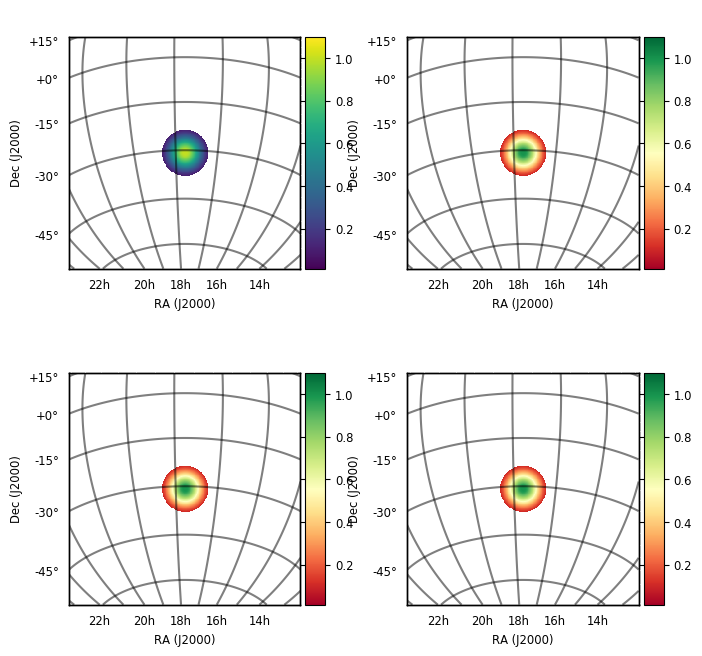

In [9]:
Image(filename='zen.2457548.46619.HH.uvcRP.uvh5.StokesPoint.flux.fits.png') 

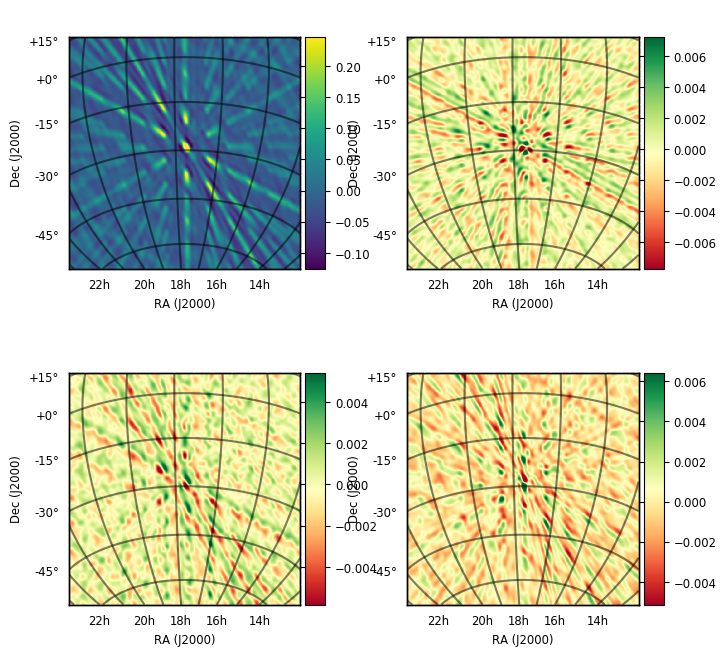

In [12]:
Image(filename='zen.2457548.46619.HH.uvcRP.uvh5.StokesPoint.image.fits.png') 

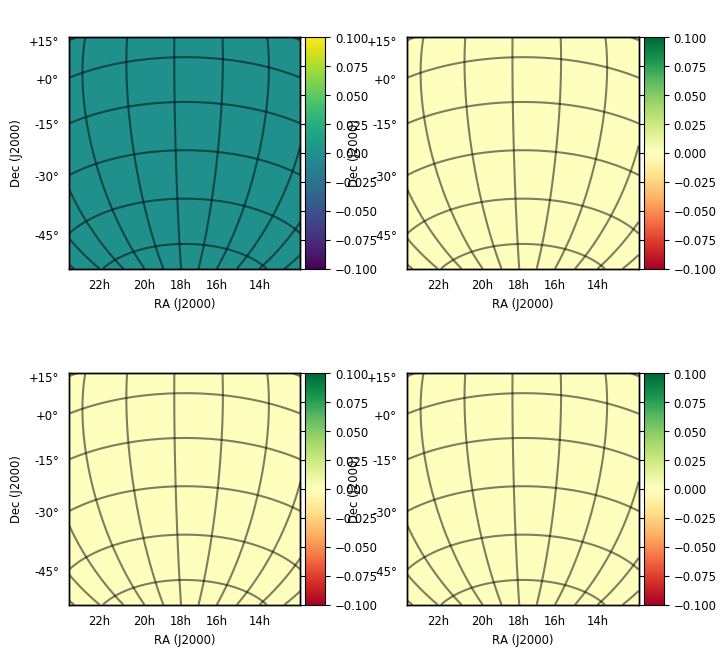

In [11]:
Image(filename='zen.2457548.46619.HH.uvcRP.uvh5.StokesPoint.model.fits.png')

## Model: Spectrally Constant Point Source Correlation Model

#### Exact CASA Commands

[xx,yy,xy,yx]

[#,0.,0.,0.] or [0.,#,0.,0.] gives you a model with visibilities in you MS for double the number in xx or double the number in yy

[#,0.,0.,0.] gives you a model with visibilities in you MS for number in xx and number in yy

[0.,#,0.,0.] gives you a model with visibilities in you MS for number in xx and number in yy

[#,0.,#,0.] gives you a model with visibilities in you MS for xx,xy,yx,yy

[#,0.,0.,#,] gives you a model with visibilities in you MS for xx,xy,yx,yy

[0.,0.,#,#] gives you a model with visibilities in you MS for xy,yx (I don't remember)

[0.,0.,0.,#] gives you a model with visibilities in you MS for xy,yx (I don't remember)

[0.,0.,#,0.] gives you a model with visibilities in you MS for xy,yx (I don't remember)

In [ ]:
#rm -rvf *.l* *linearPoint*.cl zen*linearPoint*.MS* zen*linearPoint*.image* zen*linearPoint*.model* zen*linearPoint*.flux* zen*linearPoint*.residual zen*linearPoint*.psf*
#Convert from .uvfits to .MS
#*******************************************************************
uvfit = 'zen.2457548.46619.HH.uvcRP.uvh5.uvfits'
msfile=uvfit.strip('uvfits') + 'linearPoint.MS'
importuvfits(vis=msfile,fitsfile=uvfit)
#*******************************************************************
def flag(msname): #You might have to update this. Flag MS or calibration Tables.
    flagdata(msname, flagbackup=True, mode='manual',antenna="23" ) #for HERA19
    flagdata(msname, flagbackup=True, mode='manual',antenna="44" ) #for HERA19
    flagdata(msname, flagbackup=True, mode='manual',antenna="81" ) #for HERA19
    flagdata(msname, flagbackup=True, mode='manual',antenna="82" ) #for HERA19
    flagdata(msname, flagbackup=True, mode='manual',spw="0:0~65" )#channels 0-65 of spw 0
    flagdata(msname, flagbackup=True, mode='manual',spw="0:377~387" )
    flagdata(msname, flagbackup=True, mode='manual',spw="0:850~854" )
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:930~1023")
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:831" )
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:769" )
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:511" )
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:913" )
    flagdata(msname, autocorr = True )
    
    return

def mkinitmodel(msname): #Model you give casa
    import numpy as np
    
    flux_array = np.array([0.5,0.,0.,0.])
    cl.addcomponent(flux = flux_array,fluxunit='Jy',polarization='linear' , shape = 'point' ,dir='J2000 17h45m40.0409s -29d0m28.118s')
    cl.rename('GC_linearPoint.cl')
    cl.close()
    ft(msname , complist = 'GC_linearPoint.cl' , usescratch = True )
    
    return

def phscal(msname):
    kc = os.path.basename(msname) + ".Kcal"
    bc = os.path.basename(msname) + ".Bcal"
    gaintables = []
    gaincal(msname, caltable=kc, gaintype='K', solint='inf', refant='10')
    gaintables.append(kc)
    bandpass(msname, caltable=bc, gaintable=gaintables, solint='inf',
             combine='scan', refant='10')
    #plotcal(bc, xaxis='chan', yaxis='phase', figfile="{}.phs.png".format(bc), showgui=False)
    #plotcal(bc, xaxis='chan', yaxis='amp', figfile="{}.amp.png".format(bc), showgui=False)
    gaintables.append(bc)
    applycal(msname, gaintable=gaintables)

    return
    
# Calibration and Deconvolution Process

flag(msname=msfile)
mkinitmodel(msname=msfile)
phscal(msname=msfile)

clean(msfile,msfile[:-3],niter=0,weighting = 'briggs',robust =0
      ,imsize =[512 ,512] ,pbcor=False, cell=['500 arcsec'] ,mode='mfs'
      ,nterms =1,spw='0:150~900',stokes='XXYY'
      ,interactive=False,npercycle=5,threshold='0.1mJy/beam')

plotms(msfile)

# Export CASA image and model file to FITS file
exportfits(msfile[:-3]+'.image',msfile[:-3]+'.image.fits')
exportfits(msfile[:-3]+'.model',msfile[:-3]+'.model.fits')
exportfits(msfile[:-3]+'.flux',msfile[:-3]+'.flux.fits')

# Image Calibration Solutions
tb.open(msfile+".Kcal")
gains=tb.getcol('FPARAM')
np.savez(msfile+'.Kcal.npz',gains=gains)

tb.open(msfile+".Bcal")
gains=tb.getcol('CPARAM')
np.savez(msfile+'.Bcal.npz',gains=gains)

#### Exact Python Commands

In [ ]:
# Stokes Image of CASA formatted image and model file.
import numpy as np
import matplotlib.pyplot as plt
import aplpy
from astropy import units as u
from astropy.io import fits
%matplotlib notebook

fitsbasename = "zen.2457548.46619.HH.uvcRP.uvh5.linearPoint.{}.fits"
fitsfiles = [fitsbasename.format("image"),fitsbasename.format("model"),fitsbasename.format("flux")]

for fitsfile in fitsfiles:

    f = plt.figure(figsize=(10,7))
    for pol in np.arange(2):
        fig = aplpy.FITSFigure(fitsfile,dimensions=[0,1],slices=[0,pol],figure=f,subplot=(2,2,pol+1))
        if pol == 0:
            vmax=18
            vmin=-4
            cmap='viridis'
        else:
            vmax = 1
            vmin = -1
            cmap='RdYlGn'
        fig.show_colorscale(cmap=cmap)#,vmax=vmax,vmin=vmin)#,stretch='arcsinh')
        fig.add_grid()
        fig.grid.set_color('black')
        fig.grid.set_xspacing(15)
        fig.grid.set_yspacing(15)
        fig.grid.show()
        fig.axis_labels.set_font(size='small')
        fig.tick_labels.set_font(size='small')
        fig.tick_labels.set_xformat('hh')
        fig.tick_labels.set_yformat('dd')
        fig.add_colorbar()
        fig.colorbar.set_font(size='small')

    #fig.savefig('{}.png'.format(f))
    plt.show()

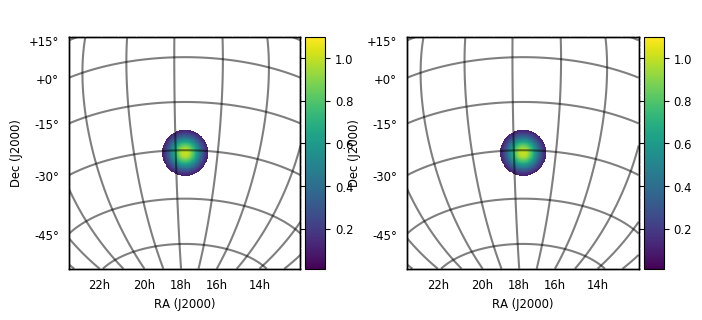

In [13]:
Image(filename='zen.2457548.46619.HH.uvcRP.uvh5.linearPoint.flux.fits.png') 

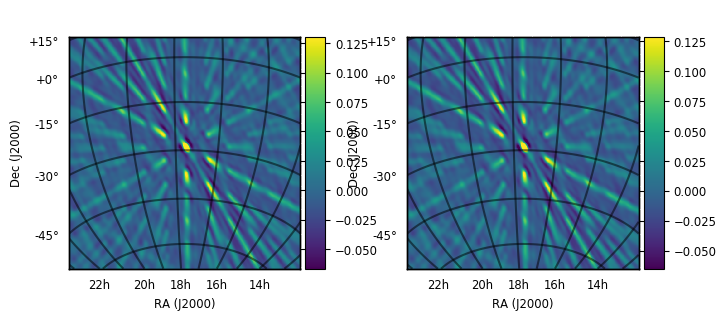

In [14]:
Image(filename='zen.2457548.46619.HH.uvcRP.uvh5.linearPoint.image.fits.png') 

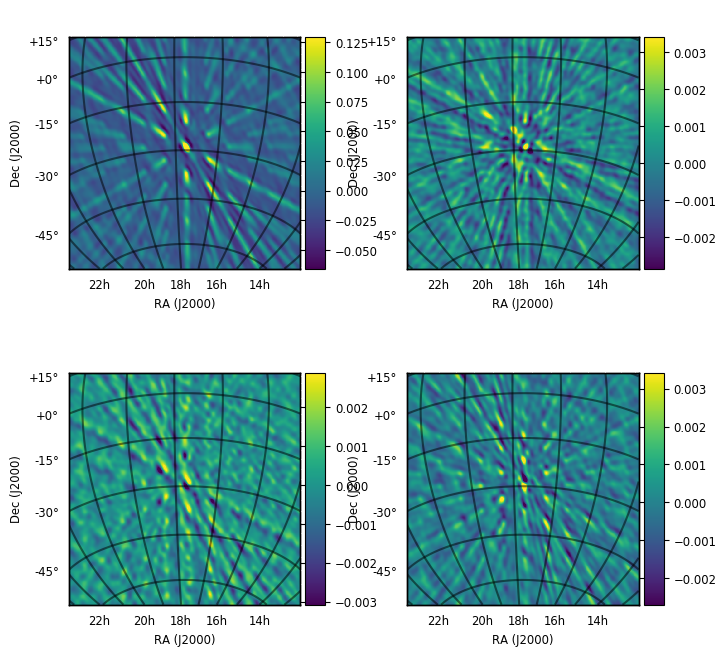

In [19]:
Image(filename='zen.2457548.46619.HH.uvcRP.uvh5.linearPoint.stokes.image.fits.png')

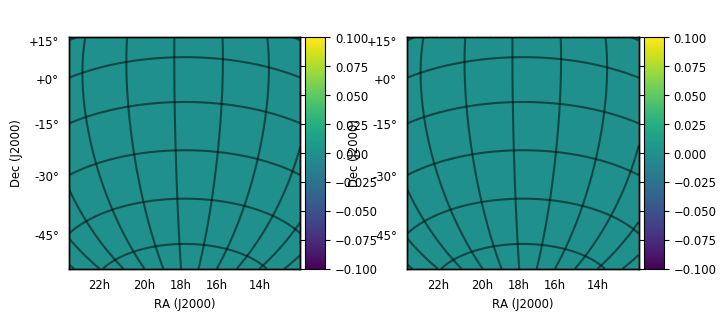

In [15]:
Image(filename='zen.2457548.46619.HH.uvcRP.uvh5.linearPoint.model.fits.png') 

## Model: Diffuse Source Stokes Spectrum Model

#### Exact CASA Commands

In [ ]:
# rm -rvf *.l* *StokesDiffuse*.cl zen*StokesDiffuse*.MS* zen*StokesDiffuse*.image* zen*StokesDiffuse*.model* zen*StokesDiffuse*.flux* zen*StokesDiffuse*.residual zen*StokesDiffuse*.psf*
#Convert from .uvfits to .MS
#*******************************************************************
uvfit = 'zen.2457548.46619.HH.uvcRP.uvh5.uvfits'
msfile=uvfit.strip('uvfits') + 'StokesDiffuse.MS'
importuvfits(vis=msfile,fitsfile=uvfit)
#*******************************************************************
def flag(msname): #You might have to update this. Flag MS or calibration Tables.
    flagdata(msname, flagbackup=True, mode='manual',antenna="23" ) #for HERA19
    flagdata(msname, flagbackup=True, mode='manual',antenna="44" ) #for HERA19
    flagdata(msname, flagbackup=True, mode='manual',antenna="81" ) #for HERA19
    flagdata(msname, flagbackup=True, mode='manual',antenna="82" ) #for HERA19
    flagdata(msname, flagbackup=True, mode='manual',spw="0:0~65" )#channels 0-65 of spw 0
    flagdata(msname, flagbackup=True, mode='manual',spw="0:377~387" )
    flagdata(msname, flagbackup=True, mode='manual',spw="0:850~854" )
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:930~1023")
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:831" )
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:769" )
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:511" )
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:913" )
    flagdata(msname, autocorr = True )
    
    return

def mkinitmodel(msname, modelname): #Model you give casa
    ft(msname , model = modelname , usescratch = True )
    
    return

def phscal(msname):
    kc = os.path.basename(msname) + ".Kcal"
    bc = os.path.basename(msname) + ".Bcal"
    gaintables = []
    gaincal(msname, caltable=kc, gaintype='K', solint='inf', refant='10')
    gaintables.append(kc)
    bandpass(msname, caltable=bc, gaintable=gaintables, solint='inf',
             combine='scan', refant='10',solnorm=False)
    #plotcal(bc, xaxis='chan', yaxis='phase', figfile="{}.phs.png".format(bc), showgui=False)
    #plotcal(bc, xaxis='chan', yaxis='amp', figfile="{}.amp.png".format(bc), showgui=False)
    gaintables.append(bc)
    applycal(msname, gaintable=gaintables)

    return
    
# Calibration and Deconvolution Process

flag(msname=msfile)
mkinitmodel(msname=msfile,
        modelname="swap_GSM_Model_of_GC_Jy_1024StokesIQUV_WithHeaderCopiedToIt.image")
phscal(msname=msfile)

clean(msfile,msfile[:-3],niter=0,weighting = 'briggs',robust =0
      ,imsize =[512 ,512] ,pbcor=False, cell=['500 arcsec'] ,mode='mfs'
      ,nterms =1,spw='0:150~900',stokes='IQUV'
      ,interactive=False,npercycle=5,threshold='0.1mJy/beam')

plotcal(caltable="zen.2457548.46619.HH.uvcRP.uvh5.StokesDiffuse.MS.Bcal",yaxis='phase',figfile="zen.2457548.46619.HH.uvcRP.uvh5.StokesDiffuse.MS.Bcal.phs.png")
plotcal(caltable="zen.2457548.46619.HH.uvcRP.uvh5.StokesDiffuse.MS.Bcal",yaxis='amp',figfile="zen.2457548.46619.HH.uvcRP.uvh5.StokesDiffuse.MS.Bcal.amp.png")

plotms(msfile)

# Export CASA image and model file to FITS file
exportfits(msfile[:-3]+'.image',msfile[:-3]+'.image.fits')
exportfits(msfile[:-3]+'.model',msfile[:-3]+'.model.fits')
exportfits(msfile[:-3]+'.flux',msfile[:-3]+'.flux.fits')

# Image Calibration Solutions
tb.open(msfile+".Kcal")
gains=tb.getcol('FPARAM')
np.savez(msfile+'.Kcal.npz',gains=gains)

tb.open(msfile+".Bcal")
gains=tb.getcol('CPARAM')
np.savez(msfile+'.Bcal.npz',gains=gains)

#### Exact Python Commands

<IPython.core.display.Javascript object>


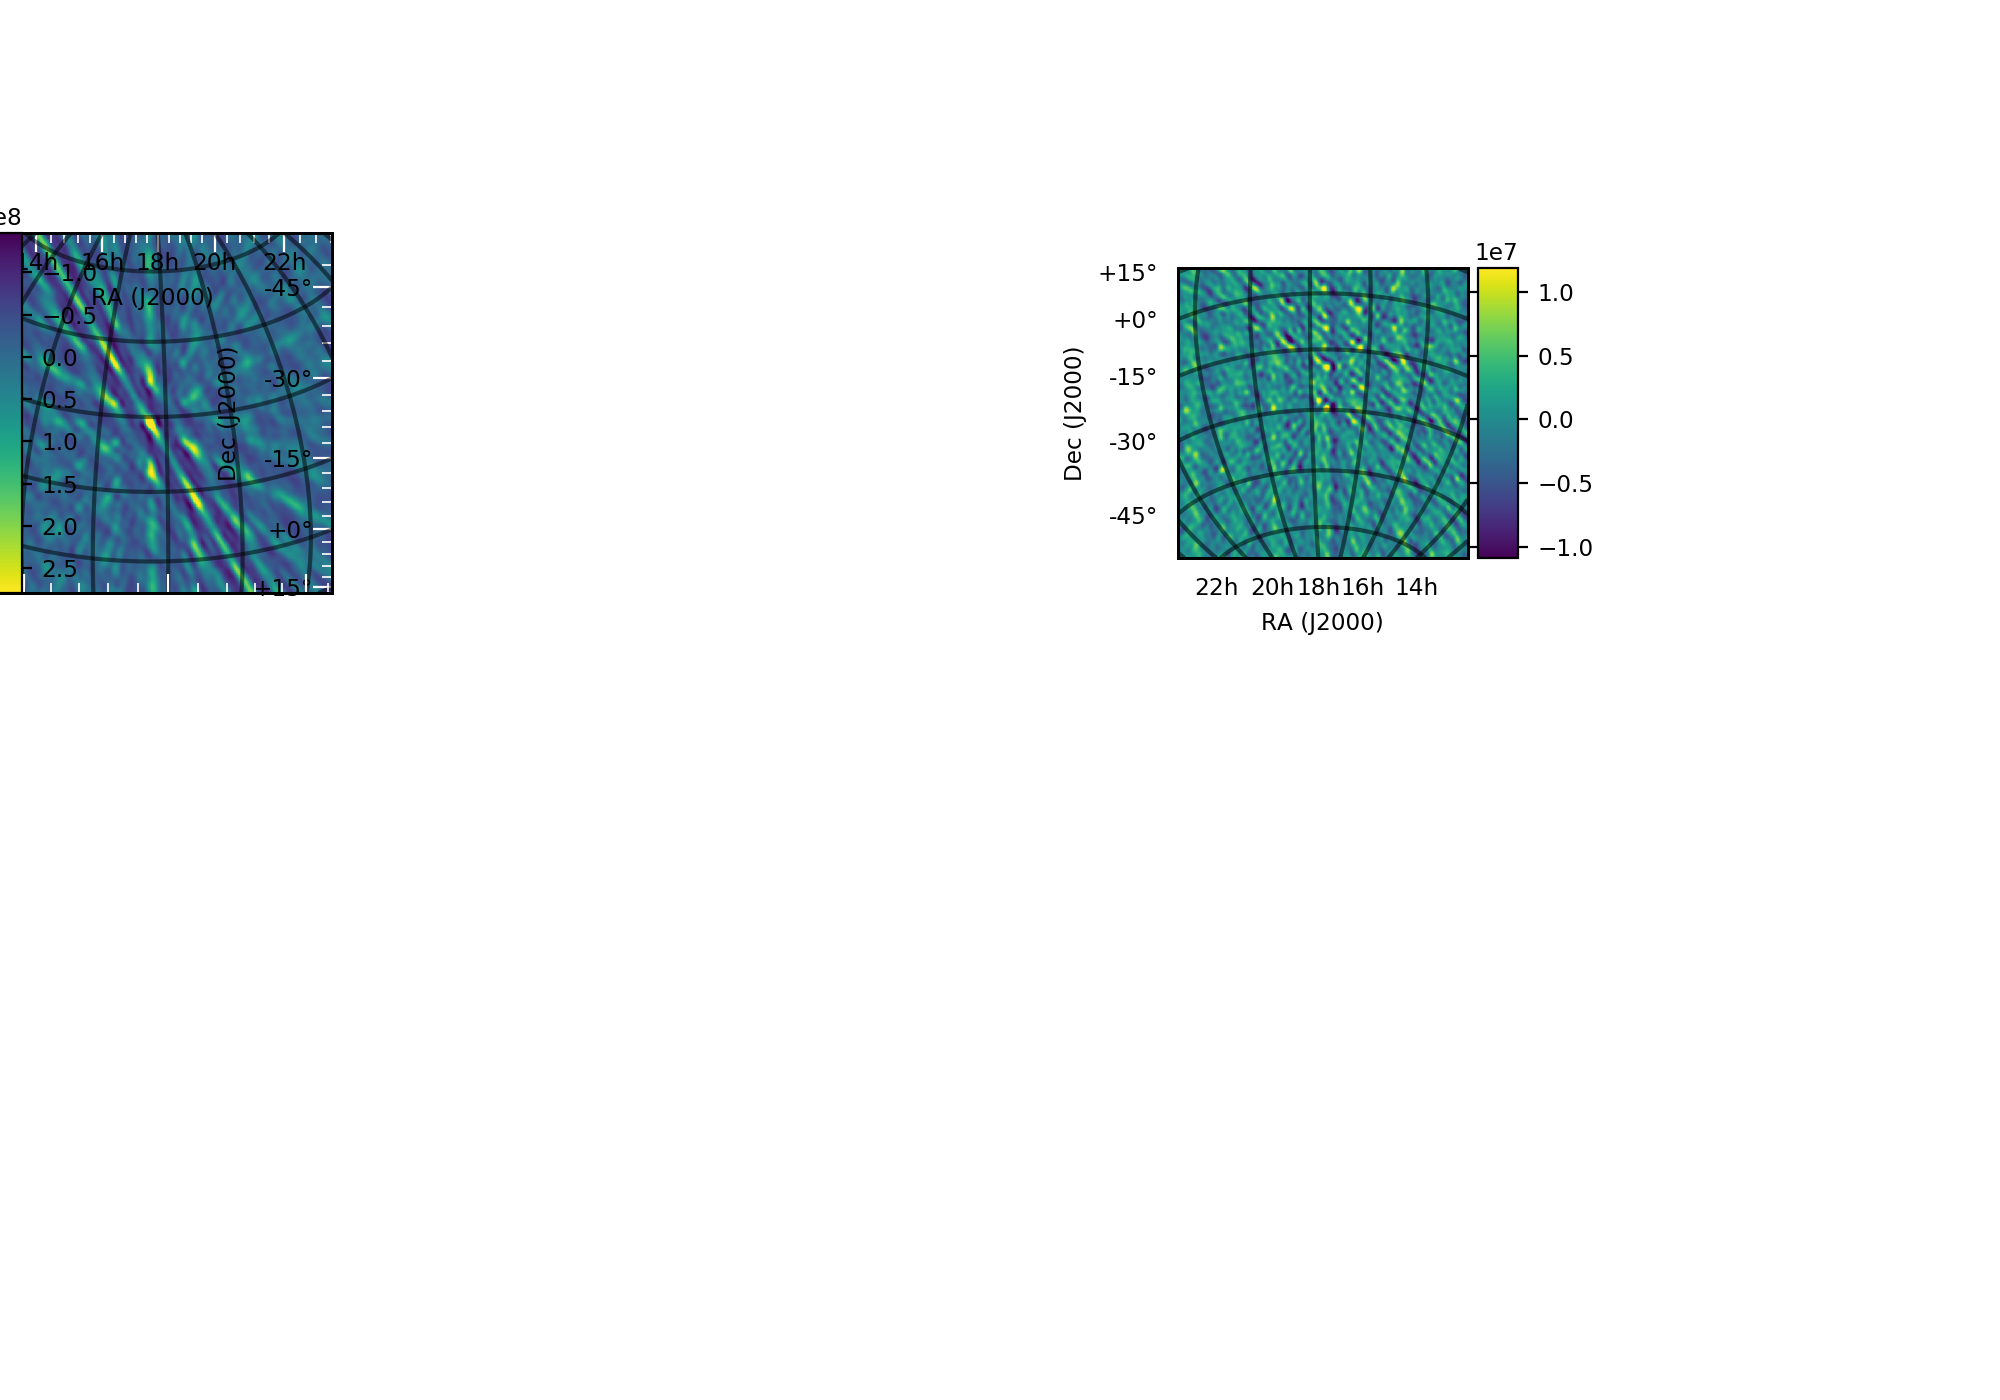

INFO: Auto-setting vmin to -1.467e+08 [aplpy.core]
INFO: Auto-setting vmax to  2.797e+08 [aplpy.core]
INFO: Auto-setting vmin to -1.090e+07 [aplpy.core]
INFO: Auto-setting vmax to  1.189e+07 [aplpy.core]


In [4]:
# Stokes Image of CASA formatted image and model file.
import numpy as np
import matplotlib.pyplot as plt
import aplpy
from astropy import units as u
from astropy.io import fits
#%matplotlib notebook

fitsbasename = "GeneralCASAModelTest/zen.2457548.46619.HH.uvcRP.uvh5.StokesDiffuse.{}.fits"
fitsfiles = [fitsbasename.format("image")]#,fitsbasename.format("model"),fitsbasename.format("flux")]

for fitsfile in fitsfiles:

    f = plt.figure(figsize=(10,7))
    for pol in np.arange(2):
        fig = aplpy.FITSFigure(fitsfile,dimensions=[0,1],slices=[0,pol],figure=f,subplot=(2,2,pol+1))
        if pol == 0:
            vmax=18
            vmin=-4
            cmap='viridis'
        else:
            vmax = 1
            vmin = -1
            cmap='RdYlGn'
        fig.show_colorscale(cmap=cmap)#,vmax=vmax,vmin=vmin)#,stretch='arcsinh')
        fig.add_grid()
        fig.grid.set_color('black')
        fig.grid.set_xspacing(15)
        fig.grid.set_yspacing(15)
        fig.grid.show()
        fig.axis_labels.set_font(size='small')
        fig.tick_labels.set_font(size='small')
        fig.tick_labels.set_xformat('hh')
        fig.tick_labels.set_yformat('dd')
        fig.add_colorbar()
        fig.colorbar.set_font(size='small')

    #fig.savefig('{}.png'.format(f))
    plt.show()

u'/Users/tashaleebillings/Desktop'

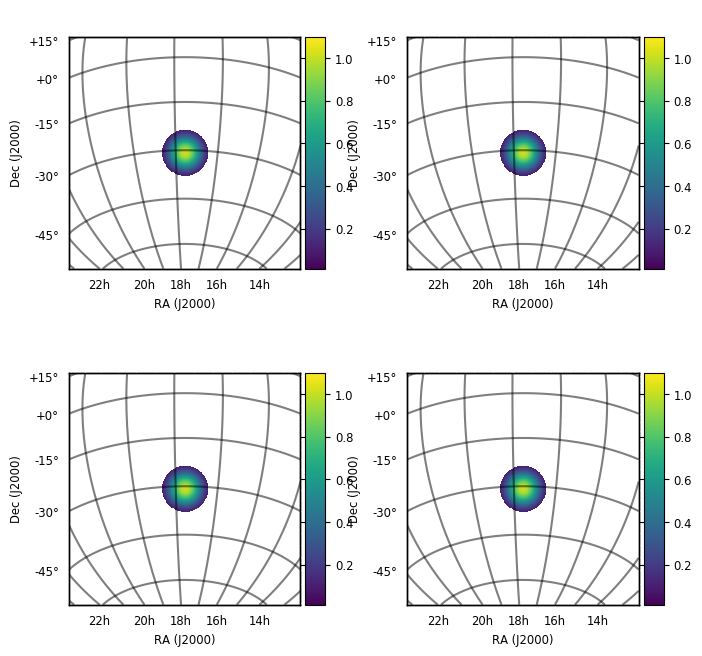

In [16]:
Image(filename='zen.2457548.46619.HH.uvcRP.uvh5.StokesDiffuse.flux.fits.png') 

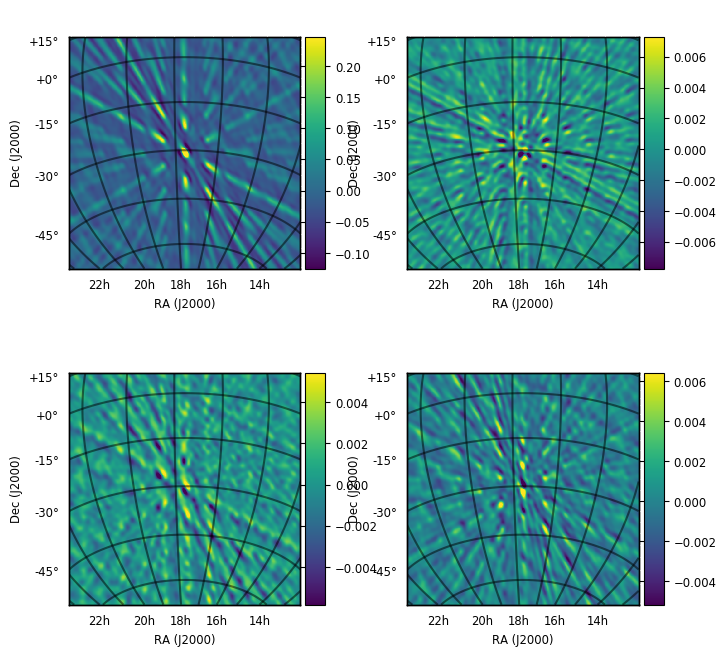

In [17]:
Image(filename='zen.2457548.46619.HH.uvcRP.uvh5.StokesDiffuse.image.fits.png') 

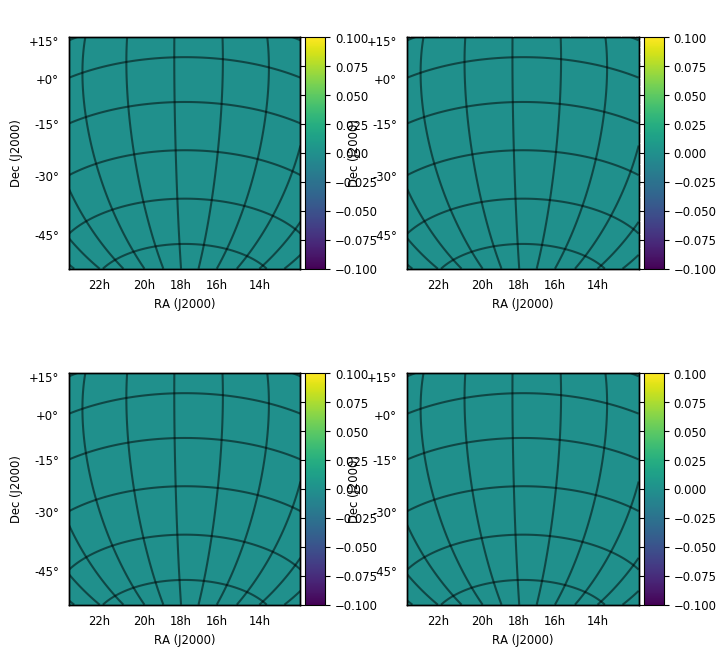

In [18]:
Image(filename='zen.2457548.46619.HH.uvcRP.uvh5.StokesDiffuse.model.fits.png')

## Model: Diffuse Source Correlation Spectrum Model

In [ ]:
#rm -rvf *.l* *CorrelationDiffuse*.cl zen*CorrelationDiffuse*.MS* zen*CorrelationDiffuse*.image* zen*CorrelationDiffuse*.model* zen*CorrelationDiffuse*.flux* zen*CorrelationDiffuse*.residual zen*CorrelationDiffuse*.psf*
#Convert from .uvfits to .MS
#*******************************************************************
uvfit = 'zen.2457548.46619.HH.uvcRP.uvh5.uvfits'
msfile=uvfit.strip('uvfits') + 'CorrelationDiffuse.MS'
importuvfits(vis=msfile,fitsfile=uvfit)
#*******************************************************************
def flag(msname): #You might have to update this. Flag MS or calibration Tables.
    flagdata(msname, flagbackup=True, mode='manual',antenna="23" ) #for HERA19
    flagdata(msname, flagbackup=True, mode='manual',antenna="44" ) #for HERA19
    flagdata(msname, flagbackup=True, mode='manual',antenna="81" ) #for HERA19
    flagdata(msname, flagbackup=True, mode='manual',antenna="82" ) #for HERA19
    flagdata(msname, flagbackup=True, mode='manual',spw="0:0~65" )#channels 0-65 of spw 0
    flagdata(msname, flagbackup=True, mode='manual',spw="0:377~387" )
    flagdata(msname, flagbackup=True, mode='manual',spw="0:850~854" )
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:930~1023")
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:831" )
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:769" )
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:511" )
    flagdata(msname, flagbackup=True, mode = 'manual' , spw = "0:913" )
    flagdata(msname, autocorr = True )
    
    return

def mkinitmodel(msname, modelname): #Model you give casa
    ft(msname , model = modelname , usescratch = True )
    
    return

def phscal(msname):
    kc = os.path.basename(msname) + ".Kcal"
    bc = os.path.basename(msname) + ".Bcal"
    gaintables = []
    gaincal(msname, caltable=kc, gaintype='K', solint='inf', refant='10')
    gaintables.append(kc)
    bandpass(msname, caltable=bc, gaintable=gaintables, solint='inf',
             combine='scan', refant='10')
    #plotcal(bc, xaxis='chan', yaxis='phase', figfile="{}.phs.png".format(bc), showgui=False)
    #plotcal(bc, xaxis='chan', yaxis='amp', figfile="{}.amp.png".format(bc), showgui=False)
    gaintables.append(bc)
    applycal(msname, gaintable=gaintables)

    return
    
# Calibration and Deconvolution Process

flag(msname=msfile)
mkinitmodel(msname=msfile,
        modelname="/Users/tashaleebillings/Desktop/GeneralCASAModelTest/AxisSwap_GSM_Model_of_GC_Jy_1024XXXYYXYY_WithHeaderCopiedToIt.image")
phscal(msname=msfile)

clean(msfile,msfile[:-3],niter=0,weighting = 'briggs',robust =0
      ,imsize =[512 ,512] ,pbcor=False, cell=['500 arcsec'] ,mode='mfs'
      ,nterms =1,spw='0:150~900',stokes='XXYY'
      ,interactive=False,npercycle=5,threshold='0.1mJy/beam')

plotms(msfile)

# Export CASA image and model file to FITS file
exportfits(msfile[:-3]+'.image',msfile[:-3]+'.image.fits')
exportfits(msfile[:-3]+'.model',msfile[:-3]+'.model.fits')
exportfits(msfile[:-3]+'.flux',msfile[:-3]+'.flux.fits')

# Image Calibration Solutions
tb.open(msfile+".Kcal")
gains=tb.getcol('FPARAM')
np.savez(msfile+'.Kcal.npz',gains=gains)

tb.open(msfile+".Bcal")
gains=tb.getcol('CPARAM')
np.savez(msfile+'.Bcal.npz',gains=gains)

#### Exact Python Commands

In [ ]:
# Stokes Image of CASA formatted image and model file.
import numpy as np
import matplotlib.pyplot as plt
import aplpy
from astropy import units as u
from astropy.io import fits
%matplotlib notebook

fitsbasename = "zen.2457548.46619.HH.uvcRP.uvh5.CorrelationDiffuse.{}.fits"
fitsfiles = [fitsbasename.format("image"),fitsbasename.format("model"),fitsbasename.format("flux")]

for fitsfile in fitsfiles:

    f = plt.figure(figsize=(10,7))
    for pol in np.arange(2):
        fig = aplpy.FITSFigure(fitsfile,dimensions=[0,1],slices=[0,pol],figure=f,subplot=(2,2,pol+1))
        if pol == 0:
            vmax=18
            vmin=-4
            cmap='viridis'
        else:
            vmax = 1
            vmin = -1
            cmap='viridis'
        fig.show_colorscale(cmap=cmap)#,vmax=vmax,vmin=vmin)#,stretch='arcsinh')
        fig.add_grid()
        fig.grid.set_color('black')
        fig.grid.set_xspacing(15)
        fig.grid.set_yspacing(15)
        fig.grid.show()
        fig.axis_labels.set_font(size='small')
        fig.tick_labels.set_font(size='small')
        fig.tick_labels.set_xformat('hh')
        fig.tick_labels.set_yformat('dd')
        fig.add_colorbar()
        fig.colorbar.set_font(size='small')

    #fig.savefig('{}.png'.format(f))
    plt.show()

In [ ]:
pwd